## Importing libraries from different sources

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt  
import matplotlib.pyplot as plt

## Dataset loading functions 

In [2]:


class CustomDataset(Dataset):
    def __init__(self, features, labels=None):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if self.labels is not None:
            return self.features[idx], self.labels[idx]
        return self.features[idx]


## Feature Extractor with Pre-trained ResNet50

In [3]:

class FeatureExtractor:
    def __init__(self):
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.model = nn.Sequential(*list(resnet.children())[:-1])  # Removing the final classification layer
        for param in resnet.parameters():
            param.requires_grad = False  # Freezing all layers
        for param in resnet.layer4.parameters():  # Unfreezing last block
            param.requires_grad = True
        self.model.eval()

    def extract(self, images):
        images = images.permute(0, 3, 1, 2)
        transform = transforms.Compose([
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        images = transform(images)
        with torch.no_grad():
            features = self.model(images).squeeze()  # Extracting features
        return features


## Neural Network Classifier


In [4]:

class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

# Labelling Smoothing Loss
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        confidence = 1.0 - self.smoothing
        smooth_label = self.smoothing / pred.size(1)
        one_hot = torch.zeros_like(pred).scatter(1, target.unsqueeze(1), 1)
        log_probs = pred.log_softmax(dim=-1)
        return -(confidence * one_hot + smooth_label).mul(log_probs).sum(dim=1).mean()


##  Evaluating model accuracy


In [5]:


def evaluate_model(model, dataset_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for features, labels in dataset_loader:
            features, labels = features.to(device), labels.to(device)
            preds = model(features)
            preds = torch.argmax(preds, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return accuracy_score(all_labels, all_preds)

# Loading data
def load_data(path):
    data = torch.load(path, weights_only=False)
    images = data.get('data')
    if images is None:
        raise ValueError(f"'data' key is missing or None in file: {path}")

    labels = data.get('targets')
    if labels is None:
        labels = None

    features = torch.tensor(images / 255.0, dtype=torch.float32).contiguous()
    if labels is not None:
        labels = torch.tensor(labels, dtype=torch.long)
    return features, labels

# Learing the models for different datasets using main function and plotting the results in matrix format

Model trained on D1, evaluated on D1: Accuracy = 0.6452
Model trained on D2, evaluated on D1: Accuracy = 0.6456
Model trained on D2, evaluated on D2: Accuracy = 0.6388
Model trained on D3, evaluated on D1: Accuracy = 0.6460
Model trained on D3, evaluated on D2: Accuracy = 0.6388
Model trained on D3, evaluated on D3: Accuracy = 0.6508
Model trained on D4, evaluated on D1: Accuracy = 0.6460
Model trained on D4, evaluated on D2: Accuracy = 0.6388
Model trained on D4, evaluated on D3: Accuracy = 0.6508
Model trained on D4, evaluated on D4: Accuracy = 0.6464
Model trained on D5, evaluated on D1: Accuracy = 0.6456
Model trained on D5, evaluated on D2: Accuracy = 0.6392
Model trained on D5, evaluated on D3: Accuracy = 0.6512
Model trained on D5, evaluated on D4: Accuracy = 0.6468
Model trained on D5, evaluated on D5: Accuracy = 0.6508
Model trained on D6, evaluated on D1: Accuracy = 0.6456
Model trained on D6, evaluated on D2: Accuracy = 0.6396
Model trained on D6, evaluated on D3: Accuracy =

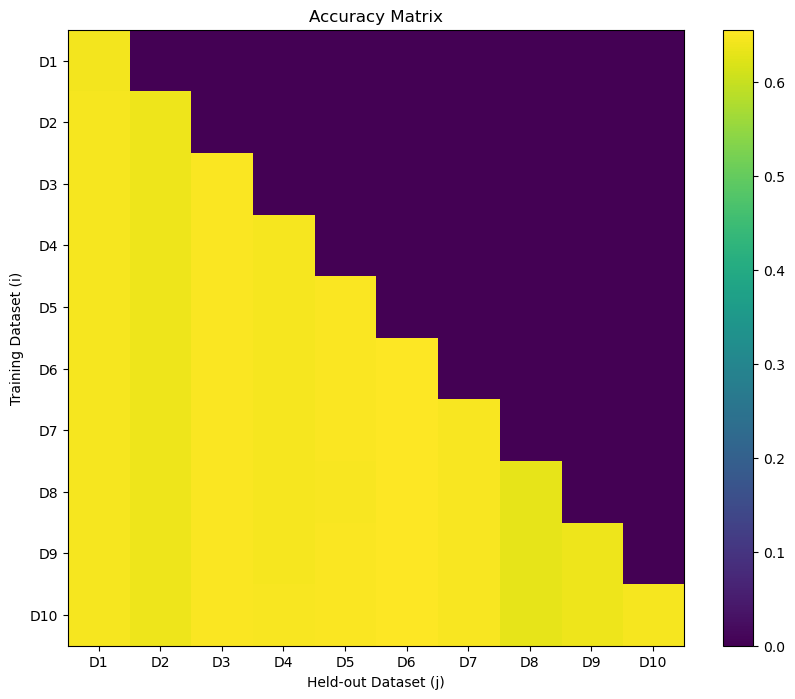

Model saved as pretrained_model.pth


In [6]:
# Main function
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = 10
    batch_size = 64
    feature_dim = 2048  # ResNet-50 feature dimension
    num_epochs = 20

    train_data_paths = [f"dataset/dataset/part_one_dataset/train_data/{i}_train_data.tar.pth" for i in range(1, 11)]
    heldout_data_paths = [f"dataset/dataset/part_one_dataset/eval_data/{i}_eval_data.tar.pth" for i in range(1, 11)]

    feature_extractor = FeatureExtractor()  # Instantiating the feature extractor
    classifier = Classifier(input_dim=feature_dim, num_classes=num_classes).to(device)
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    criterion = LabelSmoothingLoss(smoothing=0.1)

    accuracy_matrix = np.zeros((10, 10))  # (i, j) for accuracy on i-th model with j-th dataset

    for i, train_path in enumerate(train_data_paths):
        # loading training data
        train_features, train_labels = load_data(train_path)
        train_features = feature_extractor.extract(train_features.to(device))

        # training classifier for the first dataset (i = 0)
        if i == 0:
            if train_labels is None:
                raise ValueError("Dataset D1 must have labels for training.")
            train_labels = train_labels.to(device)

            train_dataset = DataLoader(CustomDataset(train_features, train_labels), batch_size=batch_size, shuffle=True)
            classifier.train()
            for epoch in range(num_epochs):
                for features, labels in train_dataset:
                    features, labels = features.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = classifier(features)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                scheduler.step()
        else:
            # pseudo-labelling training data for datasets i > 0
            classifier.eval()
            with torch.no_grad():
                pseudo_labels = torch.argmax(classifier(train_features), dim=1)

            pseudo_dataset = DataLoader(CustomDataset(train_features, pseudo_labels), batch_size=batch_size, shuffle=True)

            # fine-tuning classifier with pseudo-labels
            classifier.train()
            for epoch in range(5):
                for features, labels in pseudo_dataset:
                    features, labels = features.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = classifier(features)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

        # evaluating model on held-out datasets j <= i
        for j, heldout_path in enumerate(heldout_data_paths[:i + 1]):
            heldout_features, heldout_labels = load_data(heldout_path)
            heldout_features = feature_extractor.extract(heldout_features.to(device))  # fresh feature extraction
            heldout_dataset = DataLoader(
                CustomDataset(heldout_features, heldout_labels),
                batch_size=batch_size,
                shuffle=False,
            )
            # calculating accuracy for (i, j)
            accuracy = evaluate_model(classifier, heldout_dataset, device)
            accuracy_matrix[i, j] = accuracy

            # printing intermediate results
            print(f"Model trained on D{i+1}, evaluated on D{j+1}: Accuracy = {accuracy:.4f}")

    print("\n")
    print("Final Accuracy Matrix:")
    print(accuracy_matrix)

    plt.figure(figsize=(10, 8))
    plt.imshow(accuracy_matrix, cmap="viridis", interpolation="nearest")
    plt.colorbar()
    plt.title("Accuracy Matrix")
    plt.xlabel("Held-out Dataset (j)")
    plt.ylabel("Training Dataset (i)")
    plt.xticks(np.arange(10), [f"D{i + 1}" for i in range(10)])
    plt.yticks(np.arange(10), [f"D{i + 1}" for i in range(10)])
    plt.show()

    
      # Save the trained model
    model_filename = "pretrained_model.pth"
    torch.save(classifier.state_dict(), model_filename)
    print(f"Model saved as {model_filename}")


if __name__ == "__main__":
    main()